# Optimization Models

## 1 Deterministic Linear Model: Upper Baseline

### 1.1 Mathematical Formulation

#### Indices
\begin{align*}
i = 1,\dots,n &: \quad \text{set of stocks} \\
t = 1,\dots, T &: \quad \text{set of time periods} \\
\end{align*}

#### Decision Variables
\begin{align*}
x_{it} &: \quad \text{amount of stock $i$ bought during period $t$} \\
z_{it} &: \quad \text{amount of stock $i$ owned at the end of period $t$} \\
c_{t} &: \quad \text{cash on hand at the end of period $t$} \\
\end{align*}

#### Input Data and Parameters
\begin{align*}
P_{it} &: \quad \text{price of stock $i$ during period $t$} \\
C^0 &: \quad \text{initial cash on hand for investment in stocks} \\
\alpha &: \quad \text{commission paid per dollar traded} \\
\gamma &: \quad \text{maximum percentage of individual stock of total value of portfolio} \\
\delta &: \quad \text{limit on transaction amount} \\
\end{align*}

#### Model
\begin{align*}
\max_{c,x,z} & \quad \sum_{i=1}^n P_{i,T}z_{i,T}+c_T \\
\text{s.t.}
& \quad z_{i,1} = x_{i,1} & \quad \forall i \in [1,n] \\
& \quad (1+\alpha)\sum_{i=1}^n P_{i,1}x_{i,1} \leq C^0 \\
& \quad z_{i,t} = z_{i,t-1} + x_{i,t} & \quad \forall i \in [1,n], t \in [2,T] \\
& \quad z_{i,t-1} + x_{i,t} \geq 0 & \quad \forall i \in [1,n], t \in [2,T] \\
& \quad c_{1} = C^0 - \sum_{i=1}^n P_{i,1}x_{i,1} - \alpha \sum_{i=1}^n P_{i,1}\vert x_{i,1}\vert \\
& \quad c_{t} = c_{t-1} - \sum_{i=1}^n P_{i,t}x_{i,t} - \alpha \sum_{i=1}^n P_{i,t}\vert x_{i,t}\vert & \quad  t \in [2,T] \\
& \quad -\delta(c_t + \sum_{i=1}^n z_{i,t-1}P_{i,t}) \leq \sum_{i=1}^n \vert x_{i,t} \vert P_{i,t} \leq \delta(c_t + \sum_{i=1}^n z_{i,t-1}P_{i,t}) & \quad t \in [2,T] \\
& \quad P_{i,t}z_{i,t} \leq \gamma\sum_{i=1}^n (P_{i,t}z_{i,t}) & \quad \forall i \in [1,n], t \in [2,T] \\
& \quad c_{t}, z_{i,t} \geq 0 & \quad \forall i \in [1,n], t \in [1,T] \\
\end{align*}

In [1]:
using JuMP, Gurobi, DataFrames, CSV, Plots, Dates

In [2]:
df = DataFrame(CSV.File("actual_price_matrix_500.csv"))
df_num = select(df, Not("Column1"))
df_cov = DataFrame(CSV.File("covariance_df.csv"))
Sigma = Matrix(df_cov)
P = Matrix(df_num);

In [3]:
x_warmstart = Matrix(DataFrame(CSV.File("x_output.csv")))
z_warmstart = Matrix(DataFrame(CSV.File("z_output.csv")));

In [7]:
# Define the parameters
n = size(P, 1) # Number of stocks
T = size(P, 2) # Number of time periods
C0 = 100000 # Initial cash
alpha = 0.0001 # Commission per share
gamma = 0.2 # Max percentage of individual stock
delta = 0.05 # Limit on transaction amount

# Create a model with Gurobi Optimizer
model = Model(Gurobi.Optimizer)

# Decision Variables
@variable(model, x[i=1:n, t=1:T], start = x_warmstart[i,t]) # amount of stock i bought during period t
@variable(model, z[i=1:n, t=1:T] >= 0, start = z_warmstart[i,t]) # amount of stock i owned at the end of period t
@variable(model, c[1:T] >= 0) # cash held at the end of period t
@variable(model, a[1:n, 1:T]) # auxilliary variable to linearize absolute value

print("Defined Variables \n")

# Objective: Maximize portfolio value at final period
@objective(model, Max, sum(P[i, T] * z[i, T] for i in 1:n) + c[T])

print("Defined Objective \n")

# Constraints
@constraint(model, [i=1:n], z[i, 1] == x[i, 1])
@constraint(model, (1 + alpha) * sum(P[i, 1] * x[i, 1] for i in 1:n) <= C0)
@constraint(model, [i=1:n, t in 2:T], z[i, t] == z[i, t-1] + x[i, t])
@constraint(model, c[1] == C0 - sum(P[i, 1] * x[i, 1] for i in 1:n) - alpha * sum(P[i, 1] * a[i, 1] for i in 1:n))
@constraint(model, [t in 2:T], c[t] == c[t-1] - sum(P[i, t] * x[i, t] for i in 1:n) - alpha * sum(P[i, t] * a[i, t] for i in 1:n))
@constraint(model, [i=1:n, t in 1:T], x[i,t] <= a[i,t])
@constraint(model, [i=1:n, t in 1:T], -x[i,t] <= a[i,t])
@constraint(model, [i=1:n, t in 2:T], z[i, t-1] + x[i, t] >= 0)
@constraint(model, [i=1:n, t in 2:T], -delta*(c[t] + sum(z[i, t-1] * P[i, t] for i in 1:n)) <= sum(a[i, t] * P[i, t] for i in 1:n))
@constraint(model, [i=1:n, t in 2:T], sum(a[i, t] * P[i, t] for i in 1:n) <= delta*(c[t] + sum(z[i, t-1] * P[i, t] for i in 1:n)))
@constraint(model, [i=1:n, t in 2:T], P[i, t] * z[i, t] <= gamma * sum(P[i, t] * z[i, t] for i in 1:n))
@constraint(model, [i=1:n], x[i,1] >= 0)

print("Defined Constraints. Optimizing \n")

# Solve the model
optimize!(model);

# Output the results
#println("Optimal Portfolio Value: ", objective_value(model))
#println("Stocks to buy in each period: ")
#println(value.(x))
#println("Stocks owned at the end of each period: ")
#println(value.(z))
println("Cash held at the end of each period: ")
println(value.(c))

Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-22
Defined Variables 
Defined Objective 


LoadError: InterruptException:

In [76]:
x_values = DataFrame(value.(x), :auto)
CSV.write("x_output.csv", x_values)
z_values = DataFrame(value.(z), :auto)
stock_ownership = value.(z)
CSV.write("z_output.csv", z_values);

In [ ]:
cash = value.(c)
open("c_output.txt", "w") do file
    for element in cash
        println(file, element)
    end
end

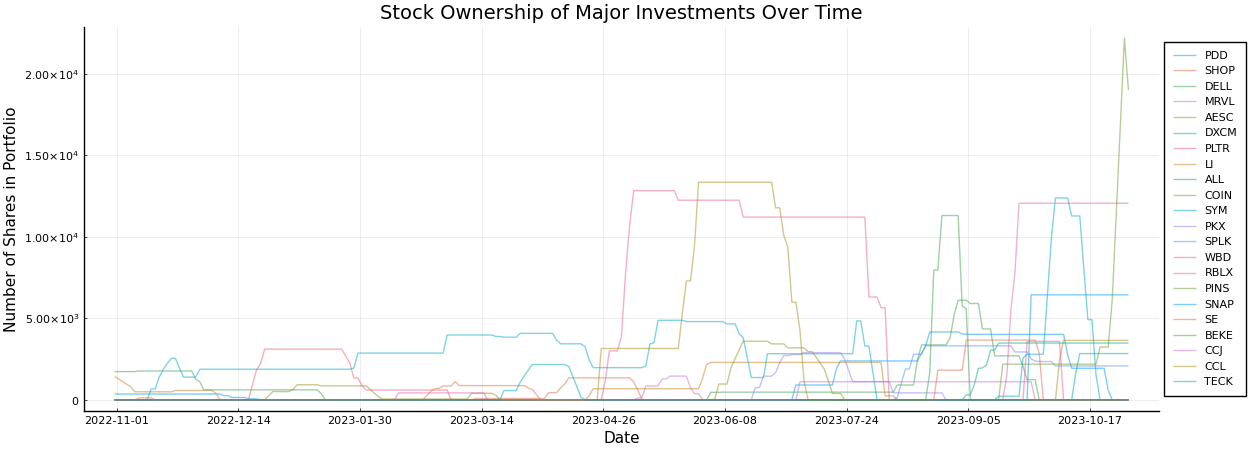

In [59]:
pyplot()

xtick_positions = 1:30:length(names(df_num))
xtick_labels = [names(df_num)[i] for i in xtick_positions]

plot(title="Stock Ownership of Major Investments Over Time", xlabel="Date", ylabel="Number of Shares in Portfolio", legend=:outerright,
     color=:viridis, xticks=(xtick_positions, xtick_labels), size=(1250, 450))

for i in 1:500
    if all(x -> x < 1000, stock_ownership[i,:])
        continue
    else
        plot!(names(df_num), stock_ownership[i, :], linealpha=0.5, label=df[i,1])
    end
end

plot!()

savefig("major_stocks_ownership_line_plot.png")

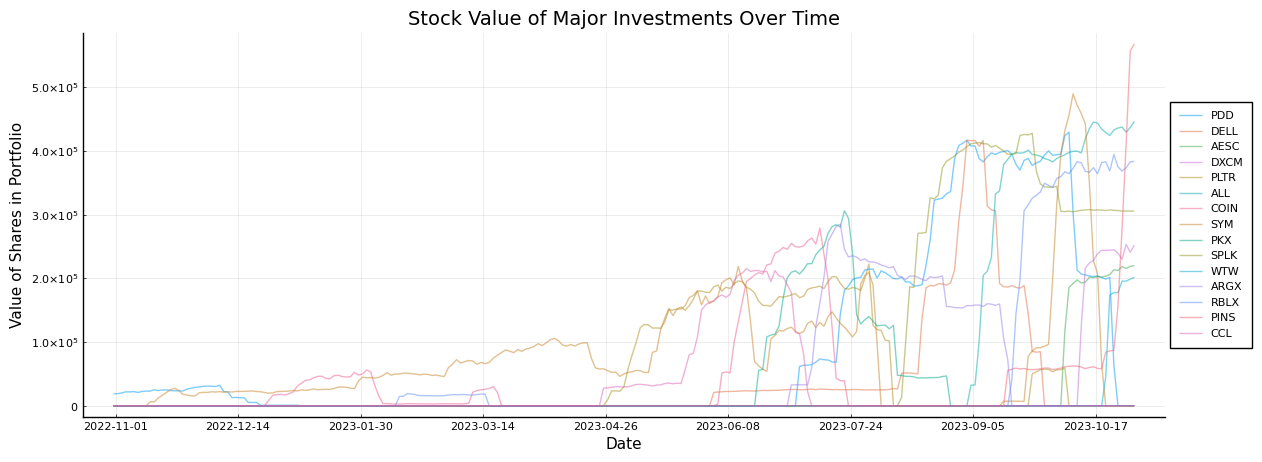

"/Users/janphilippgirgott/Library/Mobile Documents/com~apple~CloudDocs/Studium MIT/Optimization Methods/Project/major_stocks_value_line_plot.png"

In [93]:
share_value = stock_ownership .* P

pyplot()

xtick_positions = 1:30:length(names(df_num))
xtick_labels = [names(df_num)[i] for i in xtick_positions]

plot(title="Stock Value of Major Investments Over Time", xlabel="Date", ylabel="Value of Shares in Portfolio", legend=:outerright,
     color=:viridis, xticks=(xtick_positions, xtick_labels), size=(1250, 450))

for i in 1:500
    if all(x -> x < 200000, share_value[i,:])
        continue
    else
        plot!(names(df_num), share_value[i, :], linealpha=0.5, label=df[i,1])
    end
end

plot!()

savefig("major_stocks_value_line_plot.png")

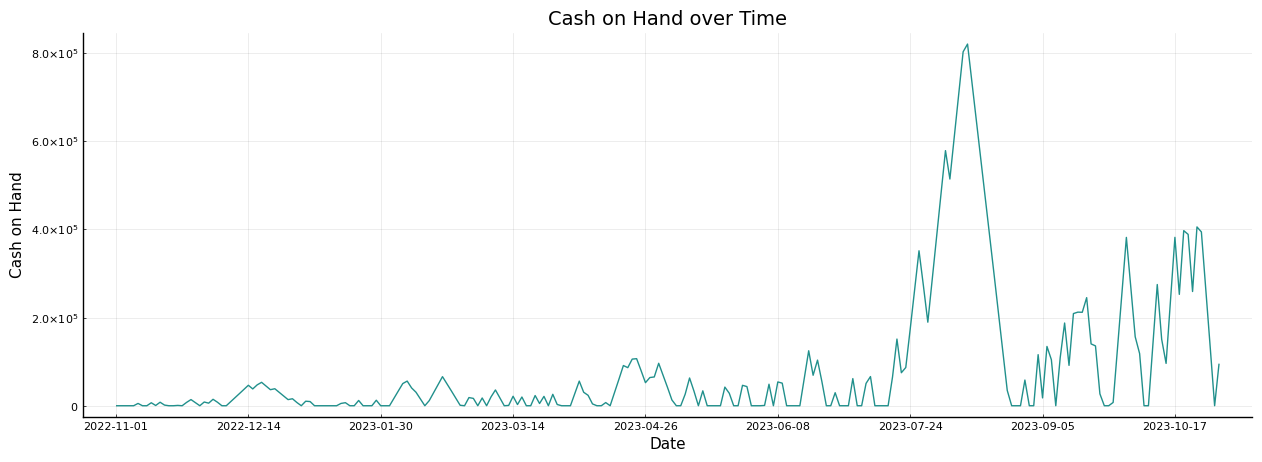

"/Users/janphilippgirgott/Library/Mobile Documents/com~apple~CloudDocs/Studium MIT/Optimization Methods/Project/cash_over_time.png"

In [82]:
pyplot()

xtick_positions = 1:30:length(names(df_num))
xtick_labels = [names(df_num)[i] for i in xtick_positions]

plot(cash, title="Cash on Hand over Time", xlabel="Date", ylabel="Cash on Hand", legend=false,
     color=:viridis, xticks=(xtick_positions, xtick_labels), size=(1250, 450))

plot!()
savefig("cash_over_time.png")

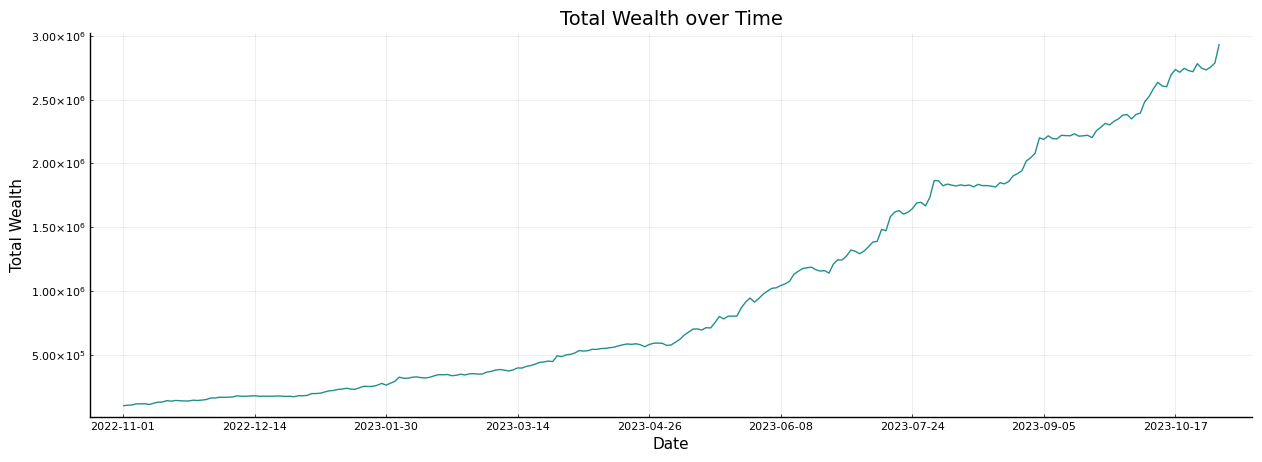

"/Users/janphilippgirgott/Library/Mobile Documents/com~apple~CloudDocs/Studium MIT/Optimization Methods/Project/total_wealth_over_time.png"

In [83]:
total_wealth = vec(sum(share_value, dims=1)) + cash;
pyplot()

xtick_positions = 1:30:length(names(df_num))
xtick_labels = [names(df_num)[i] for i in xtick_positions]

plot(total_wealth, title="Total Wealth over Time", xlabel="Date", ylabel="Total Wealth", legend=false,
     color=:viridis, xticks=(xtick_positions, xtick_labels), size=(1250, 450))

plot!()
savefig("total_wealth_over_time.png")

In [139]:
values

12-element Vector{Any}:
 153700.0432648236
 109898.10953649512
 109469.4277784228
  24984.34993230734
 219820.83335403274
 252130.85162472437
 446362.6282587225
 305818.21364752966
 201599.19357012794
 383759.2805457291
 568008.9825643367
  64492.998744431345

In [195]:
pyplot()

# Assuming 'share_value' is a 500x251 matrix
# Assuming 'df' is a DataFrame with stock names or labels in the first column

# Initialize arrays for values and labels
values = []
labels = []

# Collect non-zero values and corresponding labels
for i in 1:500
    if share_value[i, 251] != 0  # Checking the last period's value
        push!(values, share_value[i, 251])
        push!(labels, df[i, 1])  # Ensuring labels are converted to strings
    end
end

# Custom color palette and explode setting
colors = palette(:amp, length(values))
explode_setting = [i == findmax(values)[2] ? 0.1 : 0.0 for i in 1:length(values)]

# Create the pie chart
p = pie(labels, values, 
    title="Portfolio Composition in Last Period", 
    legend=:right, 
    size=(1250, 450), 
    color=colors, 
    titlefontsize=14, 
    legendfontsize=10, 
    fontfamily="Arial",
    explode=explode_setting,
    shadow=true)

# Calculate and annotate percentages
total = sum(values)
start_angle = 0

for (i, v) in enumerate(values)
    percent = v / total * 100
    if percent > 1
        mid_angle = start_angle + π * v / total
        # Increase the radius to move the annotation outside the pie
        radius = 0.8
        # Adjust this value as needed
        x_pos, y_pos = radius * cos(mid_angle), radius * sin(mid_angle)
        annotate!(x_pos, y_pos, string(round(percent, digits=1), "%"))
        start_angle += 2π * v / total
    end
end

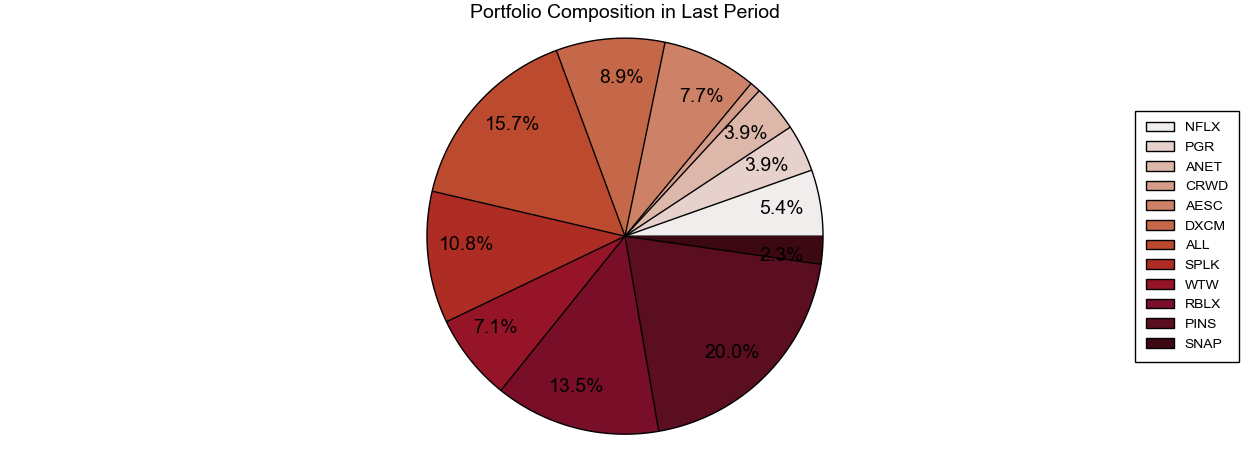

In [196]:
display(p)

## 2 Robust Model

#### Indices
\begin{align*}
i = 1,\dots,n &: \quad \text{set of stocks} \\
t = 1,\dots, T &: \quad \text{set of time periods} \\
s = 1,\dots, S &: \quad \text{set of scenarios of stock prices}
\end{align*}

#### Decision Variables
\begin{align*}
x_{it} &: \quad \text{amount of stock $i$ bought during period $t$} \\
z_{it} &: \quad \text{amount of stock $i$ owned at the end of period $t$} \\
c_{t} &: \quad \text{cash on hand at the end of period $t$} \\
\end{align*}

#### Input Data and Parameters
\begin{align*}
P_{its} &: \quad \text{price of stock $i$ in scenario $s$ during period $t$} \\
C^0 &: \quad \text{initial cash on hand for investment in stocks} \\
\Sigma_{ijs}&: \quad \text{covariance matrix of stocks $(i,j)$ in scenario $s$} \\
\alpha &: \quad \text{commission paid per dollar traded} \\
\gamma &: \quad \text{maximum percentage of individual stock of total value of portfolio} \\
\delta &: \quad \text{limit on transaction amount} \\
\sigma^2 &: \quad \text{maximum portfolio variance} \\
\end{align*}

#### Model
\begin{align*}
\max_{c,x,z} & \quad {1\over S}\sum_{i=1}^n  \sum_{s=1}^S (P_{i,T,s}z_{i,T}) +c_T \\
\text{s.t.}
& \quad {\sum_{i=1}^n \sum_{j=1}^n z_{i,t} \Sigma_{i,j,s} z_{j,t} \over \sum_{i=1}^n z_{i,t}P_{i,t,s}} \leq \sigma^2 & \quad \forall t \in [1,T] , s \in [1,S]\\
& \quad z_{i,1} = x_{i,1} & \quad \forall i \in [1,n] \\
& \quad (1+\alpha)\sum_{i=1}^n (P_{i,1,s}x_{i,1}) \leq C^0 , & \quad \forall s \in [1,S]\\
& \quad z_{i,t} = z_{i,t-1} + x_{i,t} & \quad \forall i \in [1,n], t \in [2,T] \\
& \quad z_{i,t-1} + x_{i,t} \geq 0 & \quad \forall i \in [1,n], t \in [2,T] \\
& \quad c_{1} = C^0 -\sum_{i=1}^n (P_{i,1,s}x_{i,1}) - \alpha\sum_{i=1}^n (P_{i,1,s}\vert x_{i,1}\vert) & \quad \forall s \in [1,S]\\
& \quad c_{t} = c_{t-1} - \sum_{i=1}^n (P_{i,t,s}x_{i,t}) - \alpha \sum_{i=1}^n (P_{i,t,s}\vert x_{i,t}\vert) & \quad  t \in [2,T] , s \in [1,S]\\
& \quad -\delta(c_t + \sum_{i=1}^n z_{i,t-1}P_{i,t,s}) \leq\sum_{i=1}^n (\vert x_{i,t} \vert P_{i,t,s}) \leq \delta(c_t + \sum_{i=1}^n z_{i,t-1}P_{i,t,s}) & \quad t \in [2,T] , s \in [1,S]\\
& \quad P_{i,t,s}z_{i,t} \leq \gamma\sum_{i=1}^n (P_{i,t,s}z_{i,t}) & \quad \forall i \in [1,n], t \in [2,T] , s \in [1,S]\\
& \quad c_{t}, z_{i,t} \geq 0 & \quad \forall i \in [1,n], t \in [1,T] \\
\end{align*}

In [ ]:
# Define the parameters
n = size(P, 1) # Number of stocks
T = size(P, 2) # Number of time periods
C0 = 100000 # Initial cash
alpha = 0.0001 # Commission per share
gamma = 0.2 # Max percentage of individual stock
delta = 0.05 # Limit on transaction amount
sigma = 70

# Create a model with Gurobi Optimizer
model = Model(Gurobi.Optimizer)

# Decision Variables
@variable(model, x[1:n, 1:T]) # amount of stock i bought during period t
@variable(model, z[1:n, 1:T] >= 0) # amount of stock i owned at the end of period t
@variable(model, c[1:T] >= 0) # cash held at the end of period t
@variable(model, a[1:n, 1:T]) # auxilliary variable to linearize absolute value

print("Defined Variables \n")

# Objective: Maximize portfolio value at final period
@objective(model, Max, sum(P[i, T] * z[i, T] for i in 1:n) + c[T])

print("Defined Objective \n")

# Constraints
@constraint(model, [t=1:T], sum(z[i,t] for i=1:n) * Sigma * sum(z[i,t] for i=1:n)' <= sigma^2)
@constraint(model, [i=1:n], z[i, 1] == x[i, 1])
@constraint(model, (1 + alpha) * sum(P[i, 1] * x[i, 1] for i in 1:n) <= C0)
@constraint(model, [i=1:n, t in 2:T], z[i, t] == z[i, t-1] + x[i, t])
@constraint(model, c[1] == C0 - sum(P[i, 1] * x[i, 1] for i in 1:n) - alpha * sum(P[i, 1] * a[i, 1] for i in 1:n))
@constraint(model, [t in 2:T], c[t] == c[t-1] - sum(P[i, t] * x[i, t] for i in 1:n) - alpha * sum(P[i, t] * a[i, t] for i in 1:n))
@constraint(model, [i=1:n, t in 1:T], x[i,t] <= a[i,t])
@constraint(model, [i=1:n, t in 1:T], -x[i,t] <= a[i,t])
@constraint(model, [i=1:n, t in 2:T], z[i, t-1] + x[i, t] >= 0)
@constraint(model, [i=1:n, t in 2:T], -delta*(c[t] + sum(z[i, t-1] * P[i, t] for i in 1:n)) <= sum(a[i, t] * P[i, t] for i in 1:n))
@constraint(model, [i=1:n, t in 2:T], sum(a[i, t] * P[i, t] for i in 1:n) <= delta*(c[t] + sum(z[i, t-1] * P[i, t] for i in 1:n)))
@constraint(model, [i=1:n, t in 2:T], P[i, t] * z[i, t] <= gamma * sum(P[i, t] * z[i, t] for i in 1:n))
@constraint(model, [i=1:n], x[i,1] >= 0)

print("Defined Constraints. Optimizing \n")

# Solve the model
optimize!(model);

## 3 Lower Baseline Model: Index Fund

In [26]:
nasdaq_data = DataFrame(CSV.File("Processed_NASDAQ_Data.csv"))
sort!(nasdaq_data, :Date)
initial_points = nasdaq_data."Close/Last"[1]
initial_investment = 100000;

In [27]:
nasdaq_data.portfolio_value = (1 .+(nasdaq_data."Close/Last" .- initial_points)./initial_points).*initial_investment
CSV.write("lower_baseline.csv", nasdaq_data)

"lower_baseline.csv"